
<br>
<center>
<font size='7' style="color:#0D47A1">  <b>Code Encapsulation and <br><br> Bayesian Optimization</b> </font>
</center>

<hr style= "height:3px;">
<br>


<hr style= "height:1px;">
<font size='6' style="color:#000000">  <b>Content</b> </font>
<a name="content"></a>
<br>
<br>

1. [Abstract](#abstract) 
<br>

2. [Setup](#setup)
<br>

3. [Loading Data](#loading)
<br>

4. [Explore the Data](#exploration)
<br>

5. [Pipelines Without Optimization](#pipeline)
<br>

6. [Optuna: Bayesian Optimization](#optuna)
<br>

7. [Results & Discussion](#results)
<br>

8. [Perspectives](#perspectives)
<br>

9. [References](#references)
<br>

<hr style= "height:1px;">

<br>
<br>
<br>

<font size='6' style="color:#00A6D6">  <b>1. Abstract</b> </font>
<a name="setup"></a>

[[ Back to Top ]](#content)
<br>
<br>

<font size='4'>

In this Notebook we start developing code encapsuation strategies to make our code more compact, less prone to human errors and more readible. We also begin the discussion of hyper-parameter optimization and their importance in model performance and time complexity. The code shown here has still room for improvments but serve as a first approach to illustrate how to structure a machine learning project.  

</font> 

<br>
<br>
<font size='5' style="color:#4CAF50">  <b>Purpose</b></font>

<br>
<font size='4'>
    
Construct the proper workflow for a machine learning project. 

</font> 


<br>
<br>


<br>
<br>
<font size='5' style="color:#4CAF50">  <b>Goals</b></font>


 - Define a class for data transformation.
 - Define a class for model training and evaluation.
 - Perform a simple model optimization.
 - Develope a model optimization analysis. 
 

<br>
<br>
<font size='5' style="color:#4CAF50">  <b>Methodology/Plan</b></font>

1. Optimization 1.
 - Simple Linear Models.
2. Optimization 2.
 - Complex OPtimization: Random Forest.
3. Optimization 3.
 - Optimization Analysis.
4. Optimizaiton time.
 - Comparison of time complexity. 



<br>
<br>
<br>
<br>
<br>
<br>
<br>

<font size='6' style="color:#00A6D6">  <b>2. Setup</b> </font>
<a name="setup"></a>

[[ Back to Top ]](#content)
<br>
<br>

The following imports are divided by sections according to their role in the notebook. 



In [5]:

# Basic Python Imports
# ==============================================================================
import json 
import string
from dataclasses import dataclass


# Data Science 
# ==============================================================================
import pandas as pd
import numpy as np


# Sklearn Basic imports
# ==============================================================================
import joblib
from sklearn import metrics
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split



# Sklearn anomaly detection and feature selection
# ==============================================================================
from sklearn.inspection import permutation_importance


# Rdkit import for molecular features
# ==============================================================================
! pip install rdkit-pypi
import rdkit
import rdkit.Chem
from rdkit.Chem import Fragments
from rdkit.Chem import Descriptors
from rdkit.Chem import rdchem


# Ploting 
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns



In [6]:

# Set decimals precision for pandas dataframes
# ==============================================================================
pd.set_option("display.precision", 3)


<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

<font size='6' style="color:#00A6D6">  <b>3. Loading Data</b> </font>
<a name="loading"></a>

[[ Back to Top ]](#content)

<br>
<br>
<br>


In [7]:

# Load the raw data
# ==============================================================================
df_raw = pd.read_csv('https://raw.githubusercontent.com/LilianaArguello/RIIA_test/main/data/delaney-miguel-processed.csv')
df_raw.head()


,Unnamed: 0,Molecular Weight,Polar Surface Area,Number of Rings,Number of Rings.1,Number of Valence Electrons,Number of Aromatic Atoms,Number of Conjugated Bonds,measured log solubility in mols per litre
0,1,201.225,42.24,2,2,76,11,4,-3.30
1,2,152.237,17.07,0,0,62,0,3,-2.06
2,4,84.143,0.00,1,1,26,5,0,-1.33
3,6,326.437,0.00,2,2,88,12,1,-7.32
4,7,272.388,40.46,4,4,108,6,1,-5.03


In [8]:

# Quick overview of the data statistics
# ==============================================================================
df_raw.describe()


,Unnamed: 0,Molecular Weight,Polar Surface Area,Number of Rings,Number of Rings.1,Number of Valence Electrons,Number of Aromatic Atoms,Number of Conjugated Bonds,measured log solubility in mols per litre
count,1015.000,1015.000,1015.000,1015.000,1015.000,1015.000,1015.000,1015.000,1015.000
mean,558.767,195.746,32.144,1.242,1.242,68.536,4.831,1.658,-2.939
std,325.005,93.801,29.465,1.139,1.139,31.774,4.788,1.876,1.963
min,1.000,16.043,0.000,0.000,0.000,8.000,0.000,0.000,-11.600
25%,276.000,118.245,0.000,0.000,0.000,42.000,0.000,0.000,-4.180
50%,556.000,175.000,26.300,1.000,1.000,60.000,6.000,1.000,-2.770
75%,837.500,264.647,52.775,2.000,2.000,92.000,6.000,3.000,-1.595
max,1127.000,505.206,129.420,5.000,5.000,170.000,18.000,9.000,1.580


In [9]:

# We whould never modify the raw external data so here we take the data we need and store it in our own
# dataframe for further analysis
# ==============================================================================
df = df_raw.copy(deep=True)
df.drop(columns=['Unnamed: 0','Number of Rings.1'], inplace=True)
df.head()


,Molecular Weight,Polar Surface Area,Number of Rings,Number of Valence Electrons,Number of Aromatic Atoms,Number of Conjugated Bonds,measured log solubility in mols per litre
0,201.225,42.24,2,76,11,4,-3.30
1,152.237,17.07,0,62,0,3,-2.06
2,84.143,0.00,1,26,5,0,-1.33
3,326.437,0.00,2,88,12,1,-7.32
4,272.388,40.46,4,108,6,1,-5.03


<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

<font size='6' style="color:#00A6D6">  <b>4. Explore the Data</b> </font>
<a name="exploration"></a>

[[ Back to Top ]](#content)

<br>
<br>
<br>


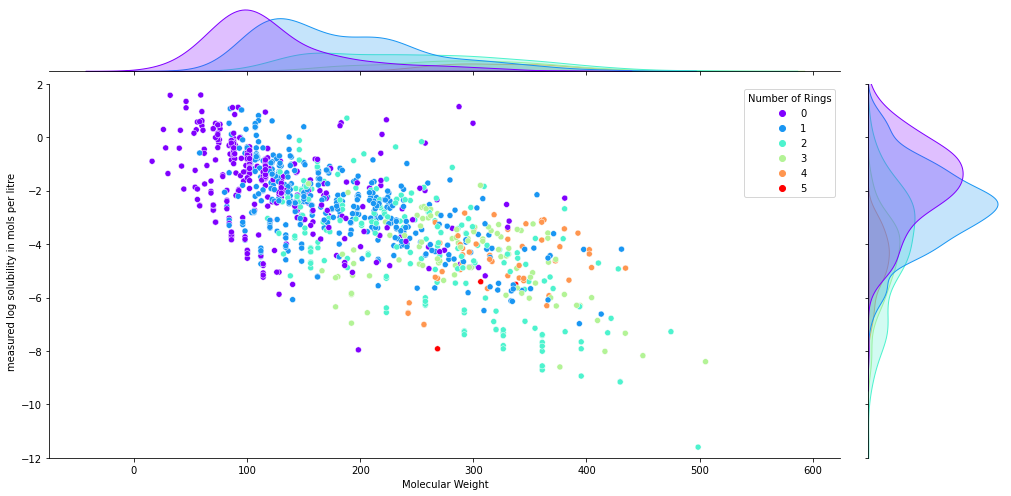

In [10]:

# Here we show the distribution of both the solubility and the molecular weight.
# Both variables grouped by the number of rings in the molecules.
# ==============================================================================
jointplot_mw = sns.jointplot(x='Molecular Weight', y='measured log solubility in mols per litre', 
               hue='Number of Rings', 
               palette='rainbow', height=7,
               data=df)

jointplot_mw.fig.set_figwidth(15)
plt.ylim(-12,2)
plt.show()


<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

<font size='6' style="color:#00A6D6">  <b>5. Pipelines Without Optimization</b> </font>
<a name="pipeline"></a>

[[ Back to Top ]](#content)

<br>
<br>
<br>


<font size='4'>

Keep in mind that all of the models presented here are used with their default parameters. This is of course a naive approach for ML modeling but for the goals already discussed in this notebook it does not represents a major issue.

Future model optimization will be performed in the next notebook if this series. 

</font> 

In [11]:

# Linear Models
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet


# SVM Models
# ==============================================================================
from sklearn.svm import SVR
from sklearn.svm import LinearSVR


# KNN Models
# ==============================================================================
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import RadiusNeighborsRegressor


# Gaussian Process Models
# ==============================================================================
from sklearn.gaussian_process import GaussianProcessRegressor


# Cross Decomposition Process Models
# ==============================================================================
from sklearn.cross_decomposition import PLSRegression


# Ensemble Models
# ==============================================================================
from sklearn.ensemble import RandomForestRegressor      # Bagging
from sklearn.ensemble import GradientBoostingRegressor  # Boosting


<br>


# Imports related to the definition of Classes to encapsulate code

<br>

In [12]:

# Feature and Target Transformation
# ==============================================================================

from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import RobustScaler


# Import the repeated k-fold object
# ==============================================================================
from sklearn.model_selection import RepeatedKFold


# Vanilla Estimator to define a sklearn model inside useful classes 
# ==============================================================================
from sklearn.base import BaseEstimator




<br>

# Pipeline for a Single Model: Linear Regression 


In [13]:

# Class to transform the input data
# ==============================================================================
class DataTransformer:
    def __init__(self, data: pd.DataFrame):
        self.data = data
        self.X = data.copy(deep=True) 
        self.X.drop(columns='measured log solubility in mols per litre', inplace=True)
        self.y = data['measured log solubility in mols per litre'].values.reshape(-1,1).astype(np.float32)
        
        self.power_transformer = PowerTransformer(method='yeo-johnson')
        self.X = self.power_transformer.fit_transform(self.X)
        
        self.robust_transformer = RobustScaler()
        self.y = self.robust_transformer.fit_transform(self.y)
        
        
    def feature_transform(self): 
        return self.X
    
    
    def target_transform(self):
        return self.y
     
    
    def inverse_target_transform(self, y_trans):
        y_ = self.robust_transformer.inverse_transform(y_trans)
        return y_
                
    

In [14]:

# Defining the datasets for the evaluation of the models
# ==============================================================================
X = DataTransformer(df).feature_transform()
y = DataTransformer(df).target_transform()


In [15]:

# Cross validation class to automatize model's evaluation
# ==============================================================================
@dataclass
class CrossValidation:
    # Memory Slots
    __slots__ = ['x', 'y', 'model','folds','repts']
    
    # Initializers
    x     : np.ndarray
    y     : np.ndarray
    model : BaseEstimator
    folds : int 
    repts : int 
        
    # Attribute
    y_min = np.amin(DataTransformer(df).inverse_target_transform(y))
    
    
    # Custome MAE function to evaluate the repeated k-fold validation
    # ==============================================================================
    def mae_cv(self):
        mae_vector = []
        cross_val = RepeatedKFold(n_splits=self.folds, n_repeats=self.repts)
        
        
        for train_index, test_index in cross_val.split(self.x, self.y):

            X_train, X_test = self.x[train_index], self.x[test_index]
            y_train, y_test = self.y[train_index], self.y[test_index]

            # fit model
            self.model.fit(X_train, y_train)

            # make predictions
            y_pred = DataTransformer(df).inverse_target_transform(self.model.predict(X_test).reshape(1, -1))
            y_pred = np.nan_to_num(y_pred, nan=np.amin(self.y_min))
            y_true = DataTransformer(df).inverse_target_transform(y_test).reshape(1, -1)

            # store
            mae = metrics.mean_absolute_error(y_pred, y_true)
            mae_vector.append(np.round(mae, decimals=4))


        return mae_vector
    
    
    
    # Custome RMSE function to evaluate the repeated k-fold validation
    # ==============================================================================
    def rmse_cv(self):
        rmse_vector = []
        cross_val = RepeatedKFold(n_splits=self.folds, n_repeats=self.repts)

        
        for train_index, test_index in cross_val.split(self.x, self.y):

            X_train, X_test = self.x[train_index], self.x[test_index]
            y_train, y_test = self.y[train_index], self.y[test_index]

            # fit model
            self.model.fit(X_train, y_train)

            # make predictions
            y_pred = DataTransformer(df).inverse_target_transform(self.model.predict(X_test).reshape(1, -1))
            y_pred = np.nan_to_num(y_pred, nan=np.amin(self.y_min))
            y_true = DataTransformer(df).inverse_target_transform(y_test).reshape(1, -1)

            # store
            rmse = np.sqrt(metrics.mean_absolute_error(y_pred, y_true))
            rmse_vector.append(np.round(rmse, decimals=4))


        return rmse_vector
    

In [16]:

# Test for the Linear Regression Model
# ==============================================================================

ref_score = np.round(np.mean(CrossValidation(X, y, LinearRegression(), 5, 6).mae_cv()), decimals=4)
ref_score


0.693

In [17]:

# Same Cross Validation for other Linear models
# ==============================================================================

ridge_score = np.round(np.mean(CrossValidation(X, y, Ridge(), 5, 6).mae_cv()), decimals=4);

# ==============================================================================

lasso_score = np.round(np.mean(CrossValidation(X, y, Lasso(), 5, 6).mae_cv()), decimals=4);

# ==============================================================================

elasticNet_score = np.round(np.mean(CrossValidation(X, y, ElasticNet(), 5, 6).mae_cv()), decimals=4);

# ==============================================================================


<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

<font size='6' style="color:#00A6D6">  <b>6. Optuna: Bayesian Optimization</b> </font>
<a name="optuna"></a>

[[ Back to Top ]](#content)

<br>
<br>
<br>


In [18]:

# Optuna Basic Import
# ==============================================================================
! pip install optuna
import optuna


     |████████████████████████████████| 302 kB 10.9 MB/s 
     |████████████████████████████████| 164 kB 26.1 MB/s 
     |████████████████████████████████| 80 kB 8.4 MB/s 
     |████████████████████████████████| 75 kB 4.4 MB/s 
     |████████████████████████████████| 49 kB 5.9 MB/s 
     |████████████████████████████████| 111 kB 50.8 MB/s 
     |████████████████████████████████| 141 kB 41.4 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=1474366165cc0309b31460f887667d527106a8889ad032e5f3780aa35e48f5f7
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


<br>

# Linear Models

<br>

In [19]:

# Objective function for the Ridge Model
# ==============================================================================
def objective_ridge(trial):
    # hyperparameter setting
    alpha_trial = trial.suggest_uniform('alpha', 0.0, 2.0)
    
    # model training and evaluation
    model = Ridge(alpha=alpha_trial)
    error_vector = CrossValidation(X, y, model, 5, 2).mae_cv()
    mean_error = np.mean(error_vector)

    # output: evaluation score
    return np.round(mean_error, decimals=4)


In [20]:

# Initialization of the model optimization
# ==============================================================================
study_ridge = optuna.create_study(direction='minimize')
study_ridge.optimize(objective_ridge, n_trials=100)


[I 2021-08-24 04:57:04,737] A new study created in memory with name: no-name-33924791-ed9e-4f02-9b6e-0329b7048cf9
[I 2021-08-24 04:57:05,452] Trial 0 finished with value: 0.693 and parameters: {'alpha': 0.8891063264614887}. Best is trial 0 with value: 0.693.
[I 2021-08-24 04:57:06,137] Trial 1 finished with value: 0.6937 and parameters: {'alpha': 1.442671717924206}. Best is trial 0 with value: 0.693.
[I 2021-08-24 04:57:06,781] Trial 2 finished with value: 0.6908 and parameters: {'alpha': 1.4012897645287599}. Best is trial 2 with value: 0.6908.
[I 2021-08-24 04:57:07,438] Trial 3 finished with value: 0.6936 and parameters: {'alpha': 0.005852371564995185}. Best is trial 2 with value: 0.6908.
[I 2021-08-24 04:57:08,104] Trial 4 finished with value: 0.6934 and parameters: {'alpha': 1.0254705537430029}. Best is trial 2 with value: 0.6908.
[I 2021-08-24 04:57:08,737] Trial 5 finished with value: 0.693 and parameters: {'alpha': 0.5349224131182071}. Best is trial 2 with value: 0.6908.
[I 2021

In [21]:

# Optimization History Plot
# ==============================================================================
optuna.visualization.plot_optimization_history(study_ridge)


In [22]:

# Run the model with Optimized parameters
# ==============================================================================
optimized_ridge = np.round(np.mean(CrossValidation(X, y, Ridge(alpha=study_ridge.best_params['alpha']), 5, 6).mae_cv()), decimals=4);


<br>
<br>
<br>
<br>
<br>

In [23]:

# Silence the run of all trials
# ==============================================================================
optuna.logging.set_verbosity(optuna.logging.WARNING)


In [24]:

# Define the objective function
# ==============================================================================
def objective_lasso(trial):
    # hyperparameter setting
    alpha_trial = trial.suggest_uniform('alpha', 0.0, 2.0)
    
    # model training and evaluation
    model = Lasso(alpha=alpha_trial)
    error_vector = CrossValidation(X, y, model, 5,2).mae_cv()
    mean_error = np.mean(error_vector)

    # output: evaluation score
    return np.round(mean_error, decimals=4)


In [25]:

# Define the optimization
# ==============================================================================
study_lasso = optuna.create_study(direction='minimize')
study_lasso.optimize(objective_lasso, n_trials=100)


In [26]:

# Optimization History Plot
# ==============================================================================
optuna.visualization.plot_optimization_history(study_lasso)


In [27]:

# Run the model with Optimized parameters
# ==============================================================================
optimized_lasso = np.round(np.mean(CrossValidation(X, y, Lasso(alpha=study_lasso.best_params['alpha']), 5, 6).mae_cv()), decimals=4);


<br>
<br>
<br>
<br>
<br>

In [28]:

# Define objective function
# ==============================================================================
def objective_elasticNet(trial):
    # hyperparameter setting
    alpha_trial    = trial.suggest_uniform('alpha', 0.0, 2.0)
    l1_ratio_trial = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
    
    
    # model training and evaluation
    model = ElasticNet(alpha=alpha_trial, l1_ratio=l1_ratio_trial)
    error_vector = CrossValidation(X, y, model, 5, 2).mae_cv()
    mean_error = np.mean(error_vector)

    # output: evaluation score
    return np.round(mean_error, decimals=4)


In [29]:

# Start the optimization
# ==============================================================================
study_elasticNet = optuna.create_study(direction='minimize')
study_elasticNet.optimize(objective_elasticNet, n_trials=100)


In [30]:

# Optimization History Plot
# ==============================================================================
optuna.visualization.plot_optimization_history(study_ridge)


In [31]:

# Run the model with Optimized parameters
# ==============================================================================
optimized_enet = np.round(np.mean(CrossValidation(X, y, 
                                                  ElasticNet(alpha=study_elasticNet.best_params['alpha'], 
                                                             l1_ratio=study_elasticNet.best_params['l1_ratio']), 
                                                             5, 6).mae_cv()), decimals=4);



In [32]:

# You can obtain a dataframe with the information of all Trials
# ==============================================================================
study_elasticNet.trials_dataframe().head(10)


,number,value,datetime_start,datetime_complete,duration,params_alpha,params_l1_ratio,state
0,0,0.756,2021-08-24 04:59:17.738623,2021-08-24 04:59:18.392182,0 days 00:00:00.653559,0.106,0.312,COMPLETE
1,1,1.554,2021-08-24 04:59:18.392270,2021-08-24 04:59:19.041948,0 days 00:00:00.649678,0.879,0.818,COMPLETE
2,2,0.926,2021-08-24 04:59:19.042038,2021-08-24 04:59:19.680913,0 days 00:00:00.638875,0.550,0.088,COMPLETE
3,3,1.153,2021-08-24 04:59:19.681003,2021-08-24 04:59:20.313473,0 days 00:00:00.632470,1.301,0.085,COMPLETE
4,4,1.365,2021-08-24 04:59:20.313630,2021-08-24 04:59:20.918316,0 days 00:00:00.604686,1.803,0.149,COMPLETE
5,5,1.554,2021-08-24 04:59:20.918421,2021-08-24 04:59:21.555287,0 days 00:00:00.636866,1.306,0.825,COMPLETE
6,6,1.555,2021-08-24 04:59:21.555393,2021-08-24 04:59:22.171444,0 days 00:00:00.616051,1.447,0.549,COMPLETE
7,7,1.515,2021-08-24 04:59:22.171593,2021-08-24 04:59:22.800287,0 days 00:00:00.628694,0.748,0.662,COMPLETE
8,8,1.554,2021-08-24 04:59:22.800417,2021-08-24 04:59:23.451957,0 days 00:00:00.651540,0.755,0.945,COMPLETE
9,9,1.557,2021-08-24 04:59:23.452062,2021-08-24 04:59:24.079615,0 days 00:00:00.627553,1.235,0.818,COMPLETE


In [33]:

# Surface plot to understand the relationship between our objective function and
# the parametrs we optimize
# ==============================================================================
optuna.visualization.plot_contour(study_elasticNet)


In [34]:

# Parametr Importance during the optimization
# ==============================================================================
optuna.visualization.plot_param_importances(study_elasticNet)


<br>
<br>
<br>
<br>
<br>

# Summary of All Runs

In [35]:

# Optimized scores vs simple scores
# ==============================================================================
print('Reference Linear Regression Score: {}'.format(ref_score))
print('Ridge Score: {} | Optimized Ridge Score: {}'.format(ridge_score, optimized_ridge))
print('Lasso Score: {} | Optimized Lasso Score: {}'.format(lasso_score, optimized_lasso))
print('ElasticNet Score: {} | Optimized ElasticNet Score: {}'.format(elasticNet_score, optimized_enet))


Reference Linear Regression Score: 0.693
Ridge Score: 0.6937 | Optimized Ridge Score: 0.6937
Lasso Score: 1.5542 | Optimized Lasso Score: 0.6934
ElasticNet Score: 1.5261 | Optimized ElasticNet Score: 0.6937


<br>
<br>
<br>
<br>
<br>

<br>

# Ensemble Model Experiments: Random Forest Regressor

<br>

## Experiment 1

In [36]:

# Define the objective function with 5 parameters as targets
# ==============================================================================
def objective_rfr(trial):

    n_estimators = trial.suggest_int('n_estimators', 30, 1000)
    max_features = trial.suggest_int('max_features', 1, 6, 1) # Decrease bias, but increase variance
    max_depth    = trial.suggest_int('max_depth', 1, 128)     # Decrease bias, but increase variance
    min_samples_split = trial.suggest_int('min_samples_split', 2, 11, 1) # Increase bias, but decrease variance
    min_samples_leaf  = trial.suggest_int('min_samples_leaf', 1, 11, 1)  # Increase bias, but decrease variance

    model = RandomForestRegressor(
            criterion = 'mae',
            n_estimators = n_estimators,
            max_features = max_features,
            max_depth = max_depth,
            min_samples_split = min_samples_split,
            min_samples_leaf = min_samples_leaf,
        )

    # model training and evaluation
    error_vector = CrossValidation(X, y, model, 5, 2).mae_cv()
    mean_error = np.mean(error_vector)

    # output: evaluation score
    return np.round(mean_error, decimals=4)


In [37]:

# Define the objective function
# ==============================================================================
study_rfr = optuna.create_study(direction='minimize')
study_rfr.optimize(objective_rfr, n_trials=4)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: DataConversionWarning:

A column-vector y was p

In [38]:

# Metrics of the optimization
# ==============================================================================
print('Best Value: {}'.format(study_rfr.best_value))
print('Best Parameters: {}'.format(study_rfr.best_params))


Best Value: 0.5221
Best Parameters: {'n_estimators': 622, 'max_features': 5, 'max_depth': 18, 'min_samples_split': 3, 'min_samples_leaf': 1}


In [39]:

# Optimization History
# ==============================================================================
optuna.visualization.plot_optimization_history(study_rfr)


In [40]:

# Parameter Importance
# ==============================================================================
optuna.visualization.plot_param_importances(study_rfr)


In [41]:

# Relationship between the hyper-parameters
# ==============================================================================
optuna.visualization.plot_parallel_coordinate(study_rfr)


In [42]:

# Optimization values for each parameter
# ==============================================================================
optuna.visualization.plot_slice(study_rfr)


<br>
<br>
<br>

## Experiment 2

In [43]:

# Filtered Objective Function
# ==============================================================================
def objective_randomForest(trial):

    n_estimators = trial.suggest_int('n_estimators', 100, 5000, 100)
    max_depth = trial.suggest_int('max_depth', 8, 64)
    max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 100, 1250, 50)

    model = RandomForestRegressor(
            criterion = 'mae',
            n_estimators = n_estimators,
            max_features = 4,
            max_depth = max_depth,
            max_leaf_nodes = max_leaf_nodes,
            min_samples_split = 3,
            min_samples_leaf = 3,
        )

    # model training and evaluation
    error_vector = CrossValidation(X, y, model, 5, 2).mae_cv()
    mean_error = np.mean(error_vector)

    # output: evaluation score
    return np.round(mean_error, decimals=4)


In [44]:

# Optimization for the Filtered Objective Function
# ==============================================================================
study_randomForest = optuna.create_study(direction='minimize')
study_randomForest.optimize(objective_randomForest, n_trials=4)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: DataConversionWarning:

A column-vector y was p

In [45]:

# Metrics of the optimization
# ==============================================================================
print('Best Value: {}'.format(study_randomForest.best_value))
print('Best Parameters: {}'.format(study_randomForest.best_params))


Best Value: 0.545
Best Parameters: {'n_estimators': 4200, 'max_depth': 49, 'max_leaf_nodes': 200}


In [46]:

# Plot for the Optimization History
# ==============================================================================
optuna.visualization.plot_optimization_history(study_randomForest)


In [47]:

# Importance Plot
# ==============================================================================
optuna.visualization.plot_param_importances(study_randomForest)


In [48]:

# Surface Plot
# ==============================================================================
optuna.visualization.plot_contour(study_randomForest)


In [49]:

# Metric and parameters
# ==============================================================================
optuna.visualization.plot_slice(study_randomForest)


<br>
<br>
<br>
<br>
<br>


# Experiment 3


In [50]:

# Final Objective Function
# ==============================================================================
def best_randomForest(trial):

    n_estimators = trial.suggest_int('n_estimators', 500, 4_000, 100)
    max_depth = trial.suggest_int('max_depth', 12, 64)

    model = RandomForestRegressor(
            criterion = 'mae',
            n_estimators = n_estimators,
            max_features = 4,
            max_depth = max_depth,
            max_leaf_nodes = 1_000,
            min_samples_split = 3,
            min_samples_leaf = 3,
        )

    # model training and evaluation
    error_vector = CrossValidation(X, y, model, 5, 2).mae_cv()
    mean_error = np.mean(error_vector)

    # output: evaluation score
    return np.round(mean_error, decimals=4)


In [51]:

# Final Optimization
# ==============================================================================
study_BestRandomForest = optuna.create_study(direction='minimize')
study_BestRandomForest.optimize(best_randomForest, n_trials=4)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: DataConversionWarning:

A column-vector y was p

In [52]:

# Best parameters for the final exploration
# ==============================================================================
study_BestRandomForest.best_params


{'max_depth': 25, 'n_estimators': 2400}

In [53]:

# Optimization History Plot
# ==============================================================================
optuna.visualization.plot_optimization_history(study_BestRandomForest)


In [54]:

# Surface Plot
# ==============================================================================
optuna.visualization.plot_contour(study_BestRandomForest)


In [55]:

# Best parameters for the final exploration
# ==============================================================================
optuna.visualization.plot_slice(study_BestRandomForest)


In [56]:

%%timeit
# Best parameters for the final exploration
# ==============================================================================
score_raw = np.round(np.mean(CrossValidation(X, y, RandomForestRegressor(n_estimators=500), 5, 6).mae_cv()), decimals=4)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: DataConversionWarning:

A column-vector y was p

1 loop, best of 5: 45.5 s per loop


In [57]:

%%timeit
# Best parameters for the final exploration
# ==============================================================================
score_opt = np.round(np.mean(CrossValidation(X, y, RandomForestRegressor(
            criterion = 'mae',
            n_estimators = 500,
            max_features = 4,
            max_depth = 19,
            max_leaf_nodes = 1000,
            min_samples_split = 3,
            min_samples_leaf = 3,
            ), 5, 6).mae_cv()), decimals=4)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: DataConversionWarning:

A column-vector y was p

1 loop, best of 5: 2min 36s per loop


In [58]:

# Best parameters for the final exploration
# ==============================================================================
print('Raw Model Time: {} s | Optimized Model Time: {} s'.format(53.1, 155))


Raw Model Time: 53.1 s | Optimized Model Time: 155 s


<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

<font size='6' style="color:#00A6D6">  <b>7. Results & Discussion</b> </font>
<a name="results"></a>

[[ Back to Top ]](#content)

<br>
<br>
<br>


<font size='4'>

In this notebbok we have created to classes that optimize the code structure, execution and workflow in general. We introduce the optimization of hyper-parameters using optuna and show different visualization techniques to interpret and optimize human analysis. 

</font> 




<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

<font size='6' style="color:#00A6D6">  <b>8. Perspectives</b> </font>
<a name="perspectives"></a>

[[ Back to Top ]](#content)

<br>
<br>
<br>



    i.   Define a Cross Val Class without warnings for the RFR.
    ii.  Define a Optimization Class for any kind of model.   
    iii. Define a Post-Optimization workflow for optimized models.
    iv.  Merge the optimization workflow with feature eng. workflow.

<br>
<br>
<br>
<br>
<br>
<br>
<font size='6' style="color:#00A6D6">  <b>9. References.</b> </font>
<a name="references"></a>

[[ Back to Top ]](#Table-of-contents)

[1] <a href=https://realpython.com/python3-object-oriented-programming/> 
    Object-Oriented Programming (OOP) in Python 3 </a> 

[2] <a href=https://realpython.com/python-data-classes/> 
    Data Classes in Python 3.7+ (Guide)</a>

[3] <a href=http://veekaybee.github.io/2019/07/08/python-type-hints/> 
       A deep dive on Python type hints</a>

[4] <a href=https://www.stat.auckland.ac.nz/~brewer/stats331.pdf> 
    Introduction to Bayesian Statistics</a>

[5] <a href=https://distill.pub/2020/bayesian-optimization/> 
    Exploring Bayesian Optimization</a>

[6] <a href=https://www.kaggle.com/awwalmalhi/hyperparameter-tuning-with-optuna-and-gridsearch> 
    HyperParameter Tuning with Optuna and GridSearch</a>